**Objectif**
L'objectif principal ici est de v√©rifier la pr√©sence de multicolin√©arit√© dans nos donn√©es.

**D√©marche**
- Etude de la coor√©lation bivari√©e entre variables
- Cette coor√©lation bivari√©e enrichit l'interpr√©tation dans la multicolin√©arit√© avec ACP

**R√©sultats**

- L'analyse d√©montre une forte multicolin√©arit√© entre les variables explicatives. La multicolin√©arit√© peut lin√©aire ou non. 
- La multicolin√©arit√© d√©couverte ici caract√©rise le cycle √©conomique par l'√©volution ensemble de la production industrielle, le revenu des m√©nages et leur consommation contre l'indicateur de la r√©cession et l'√©volution du ch√¥mage. Dans la sph√®re mon√©taire, la politique mon√©taire expansive engendre une inflation.

**Discussion**
- La solution est donc soit on supprime les variables qui apportent les m√™mes informations, soit on r√©gularise ; 
- La suppression de variables appauvrit le pouvoir explicatif de nos mod√®les. Voil√† pourquoi, on effectue id√©alement la r√©gularisation RIDGE dans le prochain fichier ;
- Il y aura quand une chance que le mod√®le VAR/VECM am√©liore les r√©sultats puisque la multicolin√©arit√© lin√©aire n'est aussi fort. 
- Commen√ßons aussi avec un mod√®le de Machine Learning capable de traiter la non lin√©arit√©.

# Package

In [28]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Importation des donn√©es

In [20]:
df_stationary_train = pd.read_csv("df_stationary_normalized_train.csv", index_col='date')
df_stationary_train.head()

UNRATE     TB3MS       RPI    INDPRO  DPCERA3M086SBEA   S&P 500  \
date                                                                            
1960-01-01 -0.707603  0.258000  1.600570  2.124429        -0.869827  0.040084   
1960-02-01 -0.975091 -0.213742  0.721466  2.124429        -0.349741 -0.604513   
1960-03-01 -0.172628 -1.166854 -0.418607 -0.021802         1.299011 -1.273115   
1960-04-01  0.005696 -1.109089 -0.385880 -1.870811         2.541907 -0.823148   
1960-05-01  0.005696 -0.675857 -0.213422 -1.445408        -0.021650 -0.374132   

            BUSLOANS  CPIAUCSL  OILPRICEx      M2SL     USREC  
date                                                           
1960-01-01  0.702241 -1.065643  -0.192303  0.159013 -0.464344  
1960-02-01  0.721912 -0.653288  -0.192303  0.251119 -0.464344  
1960-03-01 -0.497139 -0.944635  -0.192303  0.159099 -0.464344  
1960-04-01 -0.541840  0.875096  -0.192303  0.066267  2.147592  
1960-05-01 -0.015981  0.580544  -0.192303  0.516318  2.147592

In [8]:
X = df_stationary_train.drop("UNRATE", axis = 1)

# 1-Etude de la coor√©lation bivari√©e entre variables

C:\Users\Mita\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


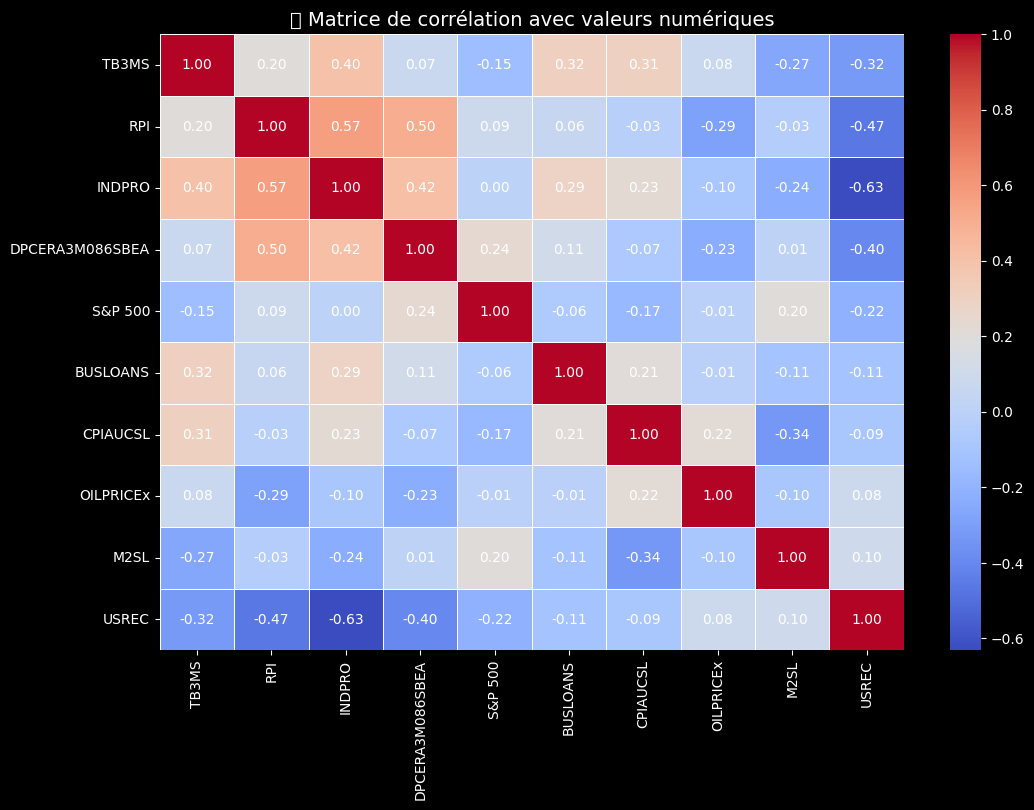

In [ ]:
# Style sombre (fond noir global)
plt.style.use("dark_background")

plt.figure(figsize=(12, 8))

# Heatmap
sns.heatmap(
    X.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.7,
    cbar=True,
    annot_kws={"color": "white"}  # chiffres lisibles sur fond sombre
)

# Titre
plt.title("üìå Matrice de corr√©lation avec valeurs num√©riques", fontsize=14, color="white")

# Axe en blanc
plt.xticks(color="white")
plt.yticks(color="white")

plt.show()

In [16]:
# Test de significativit√© de coor√©lation
results = []
for var1, var2 in itertools.combinations(X.columns, 2):
    r, p = pearsonr(X[var1], X[var2])
    results.append({
        "Variable_1": var1,
        "Variable_2": var2,
        "Correlation": r,
        "p_value": p,
        "Significatif_5pct": "Oui" if p < 0.05 else "Non"
    })

df_corr_sig = pd.DataFrame(results).sort_values(by="Correlation", ascending=False).reset_index(drop=True)

In [18]:
df_corr_sig.head()

Variable_1       Variable_2  Correlation       p_value Significatif_5pct
0        RPI           INDPRO     0.571942  1.164236e-32               Oui
1        RPI  DPCERA3M086SBEA     0.503985  1.376993e-24               Oui
2     INDPRO  DPCERA3M086SBEA     0.417863  1.202791e-16               Oui
3      TB3MS           INDPRO     0.401200  2.356429e-15               Oui
4      TB3MS         BUSLOANS     0.315146  9.643360e-10               Oui

In [19]:
df_corr_sig["Significatif_5pct"].value_counts()

Significatif_5pct
Oui    28
Non    17
Name: count, dtype: int64

Le test de significativit√© de coor√©lation entre variable explicative a fait montr√© que 28 variables sont coor√©l√©es lin√©airement entre eux. Pour plus de pr√©cision, nous allons donc effectuer maintenant une analyse ACP.

# 2- Etude de la multi-colin√©arit√© avec ACP

## Standartisation des variables dans son ensemble

In [25]:
# Que des variables quantitatives
X = (
    df_stationary_train
    .drop(columns=["UNRATE"])
    .select_dtypes(include=[np.number])
    .dropna()
)

In [26]:
# --- 2) Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Lancement de l'ACP

In [29]:
# On installe l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [30]:
# Pourcentage de variance expliqu√©e par axe
print("Variance expliqu√©e (%) :", pca.explained_variance_ratio_ * 100)

# Valeurs propres
print("Valeurs propres :", pca.explained_variance_)

Variance expliqu√©e (%) : [28.80696615 19.4428433  10.55886479  9.20132333  7.30857894  6.31776613
  6.14561879  5.14732943  4.31548878  2.75522036]
Valeurs propres : [2.88872084 1.94970016 1.05882767 0.92269538 0.73289371 0.63353644
 0.61627375 0.51616674 0.43275096 0.27628951]


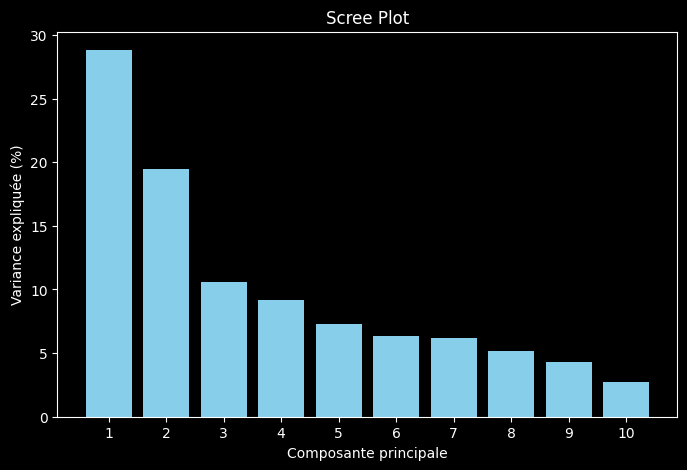

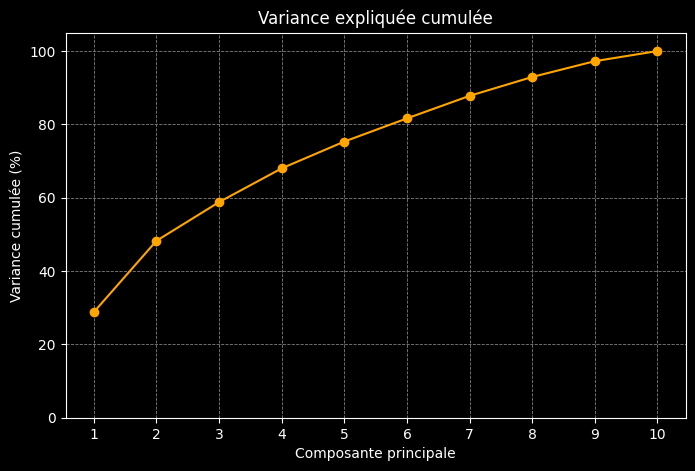

In [32]:
# Image des valeurs propres
evr = pca.explained_variance_ratio_ * 100  # en %

# --- Th√®me DARK ---
plt.style.use("dark_background")

# --- Scree Plot ---
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(evr)+1), evr, color="skyblue")
plt.xlabel("Composante principale", color="white")
plt.ylabel("Variance expliqu√©e (%)", color="white")
plt.title("Scree Plot", color="white")
plt.xticks(range(1, len(evr)+1), color="white")
plt.yticks(color="white")
plt.show()

# --- Variance cumul√©e ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(evr)+1), np.cumsum(evr), marker="o", color="orange")
plt.xlabel("Composante principale", color="white")
plt.ylabel("Variance cumul√©e (%)", color="white")
plt.title("Variance expliqu√©e cumul√©e", color="white")
plt.xticks(range(1, len(evr)+1), color="white")
plt.yticks(color="white")
plt.ylim(0, 105)
plt.grid(color="gray", linestyle="--", linewidth=0.6)  # grille lisible sur fond noir
plt.show()

L'ACP ne capte pas rapidement les informations. En effet, Les deux premiers axes expliquent √† eux seuls environ 48% de l‚Äôinertie totale. Avec trois axes, on approche 60%. Or, d'habitude, trois axes nous permettent d'aller chercher plus de 80% des informations. 

Encore une fois, c'est le signe d'une relation non lin√©aire dans les variables explicatives. Puisque l'ACP se repose sur des hypoth√®ses de lin√©arit√©. 

Essayons d'avoir les informations avec les deux premiers axes s'ils permettent d'avoir des informations sur le cycle √©conomique.

## ACP sur les 02 premiers axes

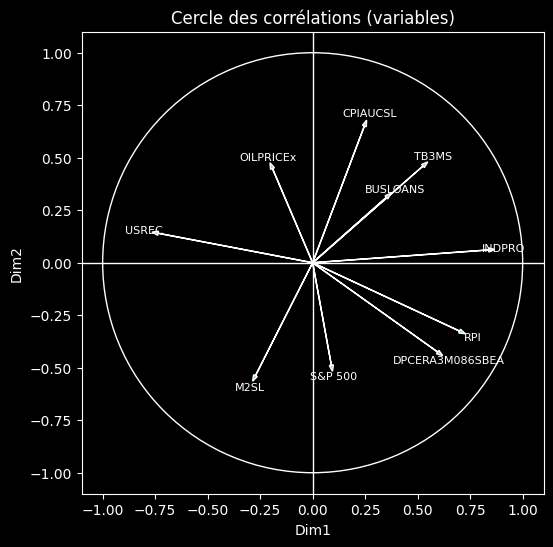

In [33]:
# Cercle des corr√©lations (variables)
# Pour donn√©es standardis√©es, corr(var, axe) = composantes * sqrt(valeurs_propres)
features = getattr(X, "columns", [f"V{i+1}" for i in range(pca.components_.shape[1])])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)   # (p x k)
corr = loadings[:, :2]

plt.figure(figsize=(6,6))
circle = plt.Circle((0, 0), 1, fill=False, linewidth=1)
plt.gca().add_artist(circle)
for i in range(corr.shape[0]):
    plt.arrow(0, 0, corr[i, 0], corr[i, 1], head_width=0.02, length_includes_head=True)
    plt.text(corr[i, 0]*1.05, corr[i, 1]*1.05, str(features[i]), ha='center', va='center', fontsize=8)
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Dim1"); plt.ylabel("Dim2")
plt.title("Cercle des corr√©lations (variables)")
plt.show()

**R√®gle d'interpr√©tations**
- Les fl√®ches proches du cercle ‚Üí variables bien repr√©sent√©es (corr√©lation forte avec les axes).
- Les fl√®ches proches du centre ‚Üí variables faiblement corr√©l√©es avec les deux axes (peu expliqu√©es).
- Les fl√®ches proches de l‚Äôun des axes ‚Üí variable corr√©l√©e fortement avec cet axe sp√©cifique.
- Les fl√®ches proches entre elles ‚Üí variables positivement corr√©l√©es.
- Les fl√®ches oppos√©es ‚Üí corr√©lation n√©gative.
- Les fl√®ches orthogonales ‚Üí ind√©pendance.
- On ajoute les r√©sultats de corr√©lation vue d'en haut pour am√©liorer les interpr√©tations.

**La multicolin√©arit√© : cycle √©conomique et sph√®re mon√©taire**

La dimension horizontale (Dimension 2) caract√©rise le cycle √©conomique, et donc la sph√®re r√©elle de l‚Äô√©conomie. Une relation n√©gative saute imm√©diatement aux yeux : USREC et INDPRO. Cela signifie que si la production industrielle augmente, l‚Äô√©conomie n‚Äôest pas en r√©cession, et inversement. La corr√©lation entre ces deux variables est la plus forte, √† -0,63. De plus, une production √©lev√©e contribue √† accro√Ætre les revenus (RPI, corr√©lation de 0,57). Une hausse du revenu influence positivement et logiquement la consommation (DPCERA3M086SBEA, corr√©lation de 0,50).

L‚Äôaxe factoriel 1, quant √† lui, illustre partiellement le comportement de la sph√®re mon√©taire. Une augmentation de l‚Äôoffre de monnaie (M2SL) tend √† accro√Ætre l‚Äôinflation mesur√©e par l‚Äôindice des prix √† la consommation (CPIAUCSL, corr√©lation de -0,34), conform√©ment √† la th√©orie quantitative de la monnaie de Milton Friedman.

On observe ainsi que la sph√®re mon√©taire pr√©sente une certaine ind√©pendance par rapport au cycle √©conomique. L‚Äôoffre mon√©taire et l‚Äôindice des prix √† la consommation sont pratiquement orthogonaux aux variables li√©es au cycle √©conomique.

En poussant l‚Äôanalyse, des relations peuvent toutefois exister entre ces deux sph√®res. Par exemple, le cr√©dit bancaire (BUSLOANS) est proche de la production industrielle (INDPRO), ce qui sugg√®re un lien potentiel, bien qu‚Äôil ne soit pas pleinement d√©montr√© par les deux premiers axes factoriels.

Chercher d‚Äôautres relations au-del√† de ces deux axes n‚Äôest pas n√©cessairement r√©v√©lateur. Environ 50 % des informations principales, capt√©es par les deux premiers axes, suffisent √† mettre en √©vidence la multicolin√©arit√© des variables li√©es au cycle √©conomique. De plus, ces axes offrent des informations pertinentes sur la sph√®re mon√©taire am√©ricaine.

L‚Äôhypoth√®se v√©rifi√©e ici est qu‚Äôune multicolin√©arit√© existe bel et bien entre les variables explicatives.

Nous ajoutons √† pr√©sent la variable suppl√©mentaire ‚Äî la cible UNRATE ‚Äî qui, sans caract√©riser les axes, enrichit l‚Äôinterpr√©tation.

# On va ajouter UNRATE comme variable suppl√©mentaire dans l'ACP

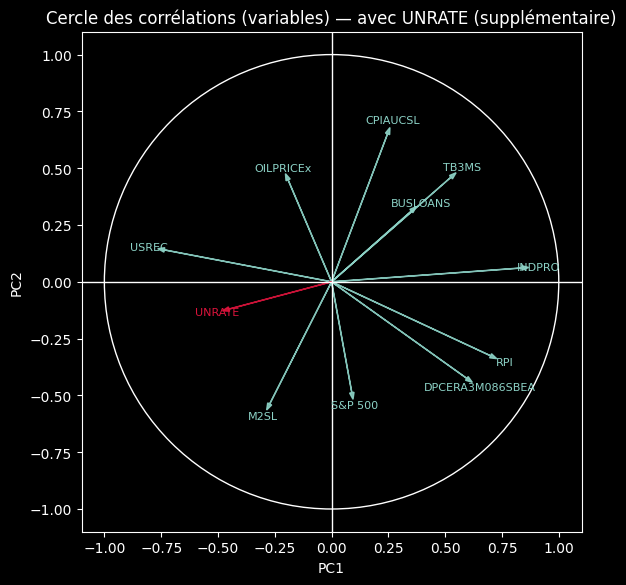

In [34]:
# --- (on suppose que X = df_stationary_train sans 'UNRATE', d√©j√† nettoy√© comme pour ta PCA) ---
# Si tu n'as pas encore les 'scores' (coordonn√©es individus), on les (re)calcule :
from sklearn.preprocessing import StandardScaler
try:
    X_scaled  # existe d√©j√† ?
except NameError:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

scores = pca.transform(X_scaled)  # (n_obs x n_PC)

# --- 1) Corr√©lations variables-axes (d√©j√† dans ton code) ---
# loadings = pca.components_.T * np.sqrt(pca.explained_variance_)   # (p x k)
# corr = loadings[:, :2]  # coordonn√©es des variables sur (PC1, PC2)

# --- 2) Ajouter UNRATE comme variable SUPPL√âMENTAIRE ---
# On aligne UNRATE sur les m√™mes lignes que X (et on retire les NaN √©ventuels c√¥t√© UNRATE)
y_all = df_stationary_train.loc[X.index, "UNRATE"].astype(float)
mask  = y_all.notna()
y     = y_all[mask].values
scores_aligned = scores[mask.values, :]  # m√™mes lignes

# Corr√©lation de UNRATE avec chaque axe (ici PC1, PC2)
r_unrate_pc1 = np.corrcoef(y, scores_aligned[:, 0])[0, 1]
r_unrate_pc2 = np.corrcoef(y, scores_aligned[:, 1])[0, 1]
unrate_coords = np.array([r_unrate_pc1, r_unrate_pc2])

# On √©tend les tableaux pour le trac√©
features_ext = list(features) + ["UNRATE"]
corr_ext = np.vstack([corr, unrate_coords])

# --- 3) Trac√© du cercle + UNRATE en couleur distincte ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.add_artist(plt.Circle((0,0), 1, fill=False, linewidth=1))

for i in range(corr_ext.shape[0]):
    is_unrate = (features_ext[i] == "UNRATE")
    color = "crimson" if is_unrate else "C0"
    ax.arrow(0, 0, corr_ext[i, 0], corr_ext[i, 1],
             head_width=0.02, length_includes_head=True, color=color, alpha=0.9)
    ax.text(corr_ext[i, 0]*1.05, corr_ext[i, 1]*1.05, str(features_ext[i]),
            ha='center', va='center', fontsize=8, color=color)

ax.axhline(0, linewidth=1); ax.axvline(0, linewidth=1)
ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title("Cercle des corr√©lations (variables) ‚Äî avec UNRATE (suppl√©mentaire)")
plt.tight_layout()
plt.show()

D'apr√®s ce qu'on voit, la corr√©lation lin√©aire avec le taux de ch√¥mage n'est pas √©lev√©e. Par contre, son ajout en tant que variable suppl√©mentaire permet de comprendre qu'elle varit inversement au cycle √©conomique des Etats-Unis.